In [47]:
import os
from matplotlib import pyplot as plt
import numpy as np

from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf


import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns

from pandas.tseries.holiday import USFederalHolidayCalendar

data_dir = '/home/silvio/dataset/jena/'

In [2]:
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [4]:
float_data.shape

(420451, 14)

In [ ]:
float_data=float_data[0:400,]
float_data.shape

# Coluna Temperatura

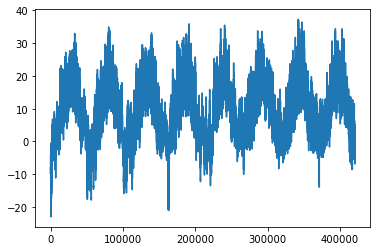

In [5]:
temp = float_data[:, 1] 
plt.plot(range(len(temp)), temp)

# amostra de intervalo de datas

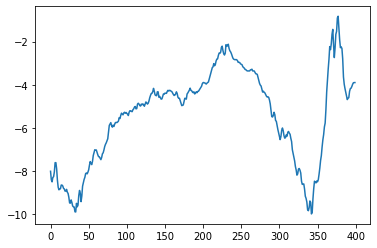

In [6]:
plt.plot(range(400), temp[:400])

# normalização

In [7]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

# dataset de dados climáticos
## Colunas
* Date Time 
* p (mbar)
* T (degC)
* Tpot (K)
* Tdew (degC)
* rh (%)
* VPmax (mbar)
* VPact (mbar)
* VPdef (mbar)
* sh (g/kg)
* H2OC (mmol/mol)
* rho (g/m**3)
* wv (m/s)
* max. wv (m/s)
* wd (deg)


# Função para auxiliar na criação de dados de treino, teste e validação
* palavra reservad yield : suporte para criação de objetos do tipo generator
* Modelo mais eficiente de leitura de dados sem comprometer a memória

In [45]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        # cria samples
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        
        #cria targets - mesmo quantidade de linhas de rows (depende do batch size)
        targets = np.zeros((len(rows),))
        #loop pela quantidade de linhas do batch
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            
            samples[j] = data[indices]
            # target é sempre a posição 1
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [46]:
#lookback = 1440
lookback = 30 # timesteps no passado
step = 5      # sample de dados
#delay = 144
delay = 10    # time steps no futuro
#batch_size = 128
batch_size = 2

In [23]:
train_gen = generator(float_data, # dados de entrada
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=3000,#200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=3000,#200001,
                    max_index=3500,#300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=3500,#300001,
                     max_index=3999,#None,
                     step=step,
                     batch_size=batch_size)

val_steps = (3500 - 3000 - lookback)

test_steps = (len(float_data) - 3500 - lookback)

In [24]:
print(type(val_gen))

<class 'generator'>


In [25]:
samples, targets = next(train_gen)
print(samples.shape)
print(targets.shape)
print(samples)
print(targets)

(2, 6, 14)
(2,)
[[[ 1.05226233 -2.1087095  -2.16751806 -2.08189502  1.06687412
   -1.35684195 -1.56189323 -0.80281834 -1.56255032 -1.56517179
    2.35181043 -1.24360504 -1.20974035 -0.16876213]
  [ 1.11357995 -2.06126527 -2.12507534 -2.03026123  1.04893938
   -1.34513714 -1.54045486 -0.79868641 -1.54379316 -1.54635739
    2.31744846 -0.04620638 -0.29584123  1.99257049]
  [ 1.19730208 -1.94378432 -2.01561778 -1.88094189  1.06687412
   -1.31132324 -1.48090386 -0.79868641 -1.48377026 -1.48756241
    2.21506865 -1.00282378 -1.04669731  0.9003586 ]
  [ 1.24682785 -1.89972897 -1.97540888 -1.8307036   1.05491763
   -1.29701736 -1.45946549 -0.79455447 -1.4650131  -1.46639622
    2.18164811 -1.15249862 -1.20974035 -0.87766076]
  [ 1.29045769 -1.84889587 -1.9284985  -1.78325634  1.00709167
   -1.28141094 -1.44040917 -0.7862906  -1.44250452 -1.44758183
    2.13975476 -0.91171736 -0.45888426 -1.83478937]
  [ 1.37417982 -1.83308112 -1.91844627 -1.78465184  0.94133097
   -1.2762088  -1.44040917 -0.7

# Percorrendo um objeto generator
* 

In [26]:
 def evaluate_naive_method():
            batch_maes = []
            for step in range(val_steps):
                samples, targets = next(val_gen)
                preds = samples[:, -1, 1]
                mae = np.mean(np.abs(preds - targets))
                batch_maes.append(mae)
            print(np.mean(batch_maes))
        


In [27]:
evaluate_naive_method()

0.12608171856419761


In [28]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

In [ ]:
#np.mean(np.abs(preds - targets))

# função para plotar loss de treino e teste

In [18]:
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

# Exemplos de Redes neurais para atacar o problema de série temporal
* MLP

In [29]:
print(lookback // step)
print(float_data.shape[-1])
print(float_data.shape)

6
14
(420451, 14)


In [30]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1]))) 
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae') 


* fit generator : função que recebe como entrada um gerador
* gera dinamicamente os dados para processamento das sequências

In [31]:
epochs=20
steps_p_epochs=200

#steps_p_epochs=500
#epochs=20

history = model.fit_generator(train_gen,
steps_per_epoch=steps_p_epochs, epochs=epochs, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
200/200 [==============================] - 2s 9ms/step - loss: 0.4946 - val_loss: 0.3297
Epoch 2/20
200/200 [==============================] - 2s 8ms/step - loss: 0.2590 - val_loss: 0.3304
Epoch 3/20
200/200 [==============================] - 2s 8ms/step - loss: 0.2264 - val_loss: 0.2844
Epoch 4/20
200/200 [==============================] - 2s 8ms/step - loss: 0.2366 - val_loss: 0.2826
Epoch 5/20
200/200 [==============================] - 2s 8ms/step - loss: 0.2229 - val_loss: 0.2407
Epoch 6/20
200/200 [==============================] - 2s 8ms/step - loss: 0.1927 - val_loss: 0.2618
Epoch 7/20
200/200 [==============================] - 2s 8ms/step - loss: 0.2326 - val_loss: 0.2069
Epoch 8/20
200/200 [==============================] - 2s 8ms/step - loss: 0.2028 - val_loss: 0.2662
Epoch 9/20
200/200 [==============================] - 2s 8ms/step - loss: 0.1885 - val_loss: 0.2050
Epoch 10/20
200/200 [==============================] - 2s 8ms/step - loss: 0.1896 - val_loss: 0.2566

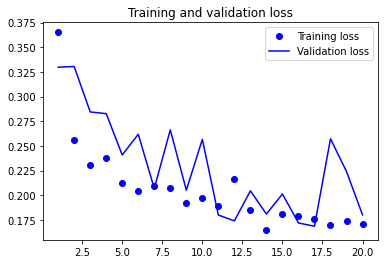

In [32]:
plot_loss(history)

# RNN

In [39]:

model = Sequential()
model.add(layers.SimpleRNN(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 7s 13ms/step - loss: 0.3504 - val_loss: 0.2156
Epoch 2/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1892 - val_loss: 0.2288
Epoch 3/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1777 - val_loss: 0.1499
Epoch 4/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1670 - val_loss: 0.2381
Epoch 5/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1494 - val_loss: 0.1467
Epoch 6/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1424 - val_loss: 0.2049
Epoch 7/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1467 - val_loss: 0.1698
Epoch 8/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1439 - val_loss: 0.2015
Epoch 9/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1602 - val_loss: 0.1661
Epoch 10/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1331 - val_lo

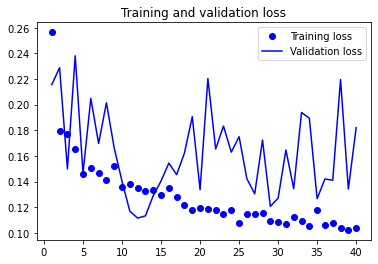

In [40]:
plot_loss(history)

# Usando camada GRU

In [33]:

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')


In [34]:
history = model.fit_generator(train_gen,
                            steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 7s 9ms/step - loss: 0.2830 - val_loss: 0.2048
Epoch 2/20
500/500 [==============================] - 4s 8ms/step - loss: 0.1721 - val_loss: 0.1100
Epoch 3/20
500/500 [==============================] - 4s 8ms/step - loss: 0.1573 - val_loss: 0.1206
Epoch 4/20
500/500 [==============================] - 4s 8ms/step - loss: 0.1553 - val_loss: 0.1197
Epoch 5/20
500/500 [==============================] - 4s 8ms/step - loss: 0.1443 - val_loss: 0.1167
Epoch 6/20
500/500 [==============================] - 4s 8ms/step - loss: 0.1443 - val_loss: 0.1421
Epoch 7/20
500/500 [==============================] - 4s 8ms/step - loss: 0.1303 - val_loss: 0.1213
Epoch 8/20
500/500 [==============================] - 4s 8ms/step - loss: 0.1407 - val_loss: 0.1150
Epoch 9/20
500/500 [==============================] - 4s 8ms/step - loss: 0.1355 - val_loss: 0.1592
Epoch 10/20
500/500 [==============================] - 4s 8ms/step - loss: 0.1319 - val_loss: 0.1107

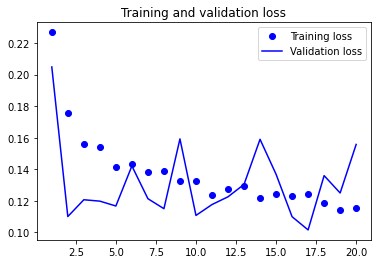

In [35]:
plot_loss(history)

# GRU 
* dropout
* recurrent_dropout

In [41]:
model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')        

In [42]:
history = model.fit_generator(train_gen,
                                      steps_per_epoch=500, epochs=40,
                              validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 19s 35ms/step - loss: 0.3906 - val_loss: 0.1577
Epoch 2/40
500/500 [==============================] - 17s 35ms/step - loss: 0.2723 - val_loss: 0.1726
Epoch 3/40
500/500 [==============================] - 17s 34ms/step - loss: 0.2624 - val_loss: 0.1313
Epoch 4/40
500/500 [==============================] - 17s 34ms/step - loss: 0.2429 - val_loss: 0.1269
Epoch 5/40
500/500 [==============================] - 17s 34ms/step - loss: 0.2380 - val_loss: 0.1098
Epoch 6/40
500/500 [==============================] - 17s 34ms/step - loss: 0.2447 - val_loss: 0.1281
Epoch 7/40
500/500 [==============================] - 17s 34ms/step - loss: 0.2305 - val_loss: 0.1215
Epoch 8/40
500/500 [==============================] - 17s 34ms/step - loss: 0.2350 - val_loss: 0.1353
Epoch 9/40
500/500 [==============================] - 17s 34ms/step - loss: 0.2090 - val_loss: 0.2717
Epoch 10/40
500/500 [==============================] - 17s 34ms/step - loss: 0.218

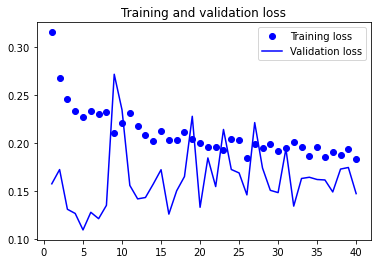

In [43]:
plot_loss(history)

# GRU 
* Duas camadas recorrentes
* return_sequences

In [36]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
plot_loss(history)

# GRU bidirecionais
* Camada LSTM

# GRU
* Camadas bidirecionais

In [ ]:
model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
plot_loss(history)

# LSTM

In [ ]:
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
ls ../dataset

In [ ]:
traffic_data = pd.read_csv('../dataset/Fremont_Bridge_Bicycle_Counter.csv', index_col='Date', parse_dates=True)
weather_data = pd.read_csv('../dataset/2500571.csv', index_col='DATE', parse_dates=True)

In [ ]:
traffic_data

In [ ]:
weather_data

In [ ]:
daily = (
    traffic_data
    .resample('d')
    .sum()
)

In [ ]:
daily = (
    daily
    .assign(
        day_of_week=lambda _df: _df.index.dayofweek
    )
    .pipe(pd.get_dummies, columns=['day_of_week'])
    .rename(
        columns={
            'day_of_week_0': 'Mon',
            'day_of_week_1': 'Tue',
            'day_of_week_2': 'Wed',
            'day_of_week_3': 'Thu',
            'day_of_week_4': 'Fri',
            'day_of_week_5': 'Sat',
            'day_of_week_6': 'Sun'
        }
    )
)
daily.head()

In [ ]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2020')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

(
    daily
    .loc[daily.holiday == 1]
)

In [ ]:
dtw=weather_data['2012-10-03':'2012-10-05']
dtw

In [ ]:
dtt=daily['2012-10-03':'2012-10-05']
dtt

# join datasets

In [ ]:
dtt=daily['2012-10-03':'2020-04-30']
print(dtt.shape)
dtw=weather_data['2012-10-03':'2020-04-30']
print(dtw.shape)
result = pd.concat([dtw, dtt], axis=1)
print(result.shape)

In [ ]:
result.describe()

In [ ]:
result.info()

In [ ]:
 dataset = result[[
 'LATITUDE',
 'LONGITUDE',
 'ELEVATION',
 'AWND',
'PRCP',
 'SNOW',
 'SNWD',
'TAVG',
'TMAX',
 'TMIN',
'WDF2',
'WDF5',
'WSF2',
'WSF5',
 'Fremont Bridge Total',
'Fremont Bridge East Sidewalk',
 'Fremont Bridge West Sidewalk',
 'Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 'holiday']]

In [ ]:
dataset.info()

In [ ]:
dataset2=dataset.fillna(dataset.mean())

In [ ]:
dataset2.info()

In [ ]:
dataset2.head()

In [ ]:
dataset2.shape

In [ ]:
import tensorflow

In [ ]:
dttotal = tensorflow.data.Dataset.from_tensor_slices(dataset2)

In [ ]:
dttotal

In [ ]:
window_size = 2

dataset3 = dataset2.head(6)
dttotal = tensorflow.data.Dataset.from_tensor_slices(dataset3)
dttotal1 = dttotal.window(window_size + 1, shift=2, drop_remainder=False)
dttotal2 = dttotal1.flat_map(lambda window: window.batch(window_size + 1))

In [ ]:
for element in dttotal2.as_numpy_iterator(): 
   print(element)